In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from math import ceil
import macti.visual

Obtención de los datos

In [2]:
TFR = pd.read_csv('UNdata_Export_20230621_205538168.zip')
# GPD per capita
GDP = pd.read_csv('UNdata_Export_20230624_011417717.zip')
# Life expectancy at birth 
LEB = pd.read_csv('UNdata_Export_20230624_013747471.zip')
# Gross enrolment ratio. Tertiary education
EDU = pd.read_csv('UNdata_Export_20230624_014454110.zip')

In [3]:
EDU.head()

,Reference Area,Time Period,Sex,Age group,Units of measurement,Observation Value
0,Afghanistan,2014,Female,Not applicable,Percent,3.67329
1,Afghanistan,2014,Male,Not applicable,Percent,13.28657
2,Afghanistan,2014,All genders,Not applicable,Percent,8.66280
3,Afghanistan,2011,Female,Not applicable,Percent,1.89233
4,Afghanistan,2011,All genders,Not applicable,Percent,3.75598


In [4]:
print(TFR.columns)
print(GDP.columns)
print(LEB.columns)
print(EDU.columns)

Index(['Country or Area', 'Year(s)', 'Variant', 'Value'], dtype='object')
Index(['Country or Area', 'Year', 'Item', 'Value'], dtype='object')
Index(['Country or Area', 'Year(s)', 'Variant', 'Value'], dtype='object')
Index(['Reference Area', 'Time Period', 'Sex', 'Age group',
       'Units of measurement', 'Observation Value'],
      dtype='object')


In [5]:
TFR_group = TFR.groupby('Country or Area')
GDP_group = GDP.groupby('Country or Area')
LEB_group = LEB.groupby('Country or Area')
EDU_group = EDU.groupby('Reference Area')

In [6]:
TFR_countries = TFR_group.groups.keys()
GDP_countries = GDP_group.groups.keys()
LEB_countries = LEB_group.groups.keys()
EDU_countries = EDU_group.groups.keys()

In [7]:
print(len(TFR_countries))
print(len(GDP_countries))
print(len(LEB_countries))
print(len(EDU_countries))

284
220
284
220


In [8]:
print(TFR_countries)

dict_keys(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Asia', 'Australia', 'Australia/New Zealand', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia (Plurinational State of)', 'Bonaire, Sint Eustatius and Saba', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Caribbean', 'Cayman Islands', 'Central African Republic', 'Central America', 'Central Asia', 'Central and Southern Asia', 'Chad', 'Chile', 'China', 'China, Hong Kong SAR', 'China, Macao SAR', 'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', 'Croatia', 'Cuba', 'CuraÃ§ao', 'Cyprus', 'Czechia', "CÃ´te d'Ivoire", "Dem. People's Republic of Korea", 'Democratic Republic of the Congo', 'Den

In [9]:
filtra_GDP = lambda p: p in GDP_countries
filtra_LEB = lambda p: p in LEB_countries
filtra_EDU = lambda p: p in EDU_countries

In [10]:
len(list(filter(filtra_EDU, list(filter(filtra_GDP, list(filter(filtra_LEB, TFR_countries)))))))

181

In [278]:
countries = list(filter(filtra_EDU, list(filter(filtra_GDP, list(filter(filtra_LEB, TFR_countries))))))

In [279]:
print(countries)

['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Ital

In [13]:
years = list(TFR_group.get_group('Afghanistan')['Year(s)'])
print(years)

[2101, 2100, 2099, 2098, 2097, 2096, 2095, 2094, 2093, 2092, 2091, 2090, 2089, 2088, 2087, 2086, 2085, 2084, 2083, 2082, 2081, 2080, 2079, 2078, 2077, 2076, 2075, 2074, 2073, 2072, 2071, 2070, 2069, 2068, 2067, 2066, 2065, 2064, 2063, 2062, 2061, 2060, 2059, 2058, 2057, 2056, 2055, 2054, 2053, 2052, 2051, 2050, 2049, 2048, 2047, 2046, 2045, 2044, 2043, 2042, 2041, 2040, 2039, 2038, 2037, 2036, 2035, 2034, 2033, 2032, 2031, 2030, 2029, 2028, 2027, 2026, 2025, 2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984, 1983, 1982, 1981, 1980, 1979, 1978, 1977, 1976, 1975, 1974, 1973, 1972, 1971, 1970, 1969, 1968, 1967, 1966, 1965, 1964, 1963, 1962, 1961, 1960, 1959, 1958, 1957, 1956, 1955, 1954, 1953, 1952, 1951, 1950]


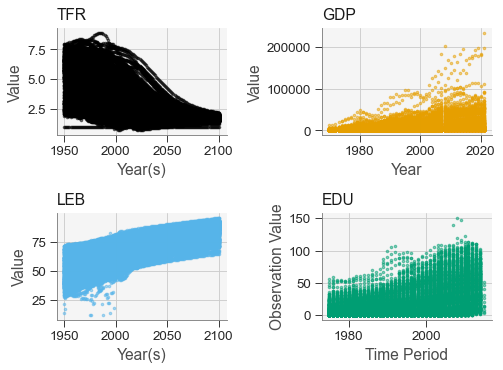

In [14]:
ax1 = plt.subplot(221)
TFR.plot(x='Year(s)', y='Value', kind='scatter', marker='.', fc='C0', alpha=0.5, ax=ax1)
ax1.set_title('TFR')

ax2 = plt.subplot(222)
GDP.plot(x='Year', y='Value', kind='scatter', marker='.', fc='C1', alpha=0.5, ax=ax2)
ax2.set_title('GDP')

ax3 = plt.subplot(223)
LEB.plot(x='Year(s)', y='Value', kind='scatter', marker='.', fc='C2', alpha=0.5, ax=ax3)
ax3.set_title('LEB')

ax4 = plt.subplot(224)
EDU.plot(x='Time Period', y='Observation Value', kind='scatter', marker='.', fc='C3', alpha=0.5, ax=ax4)
ax4.set_title('EDU')

plt.tight_layout()
plt.savefig('TFR_01.png', dpi=200)
plt.show()

In [43]:
from math import ceil

def maxmin(data, time, value, country):
    """
    Calcula el máximo y el mínimo de todos los países y los yticks.
    
    Parameters
    ----------
    paises : DataFrameGroupBy
        Dataframe generado por GroupBy con la información de los países.
        
    Returns
    -------
    p_max, y_max, p_min, y_min, yticks
        El país con el máximo valor, el valor máximo, la lista para los yticks,
        el país con el valor mínimo y el valor mínimo.
    """    
    # Se obtiene el valor máximo del time
    x_max = data[time].max()
    x_min = data[time].min()
    
    # Se obtiene el valor máximo del value
    y_max = data[value].max() 

    # Extrae el nombre del país con el valor máximo
    p_max = data[data[value] == y_max].iloc[0][country]

    # Se obtiene el valor mínimo
    y_min = data[value].min() 

    # Extrae el nombre del país con el valor mínimo
    p_min = data[data[value] == y_min].iloc[0][country]

    return p_max, y_max, p_min, y_min, x_min, x_max

def set_canvas(data, time, value, country, figsize, xstep=10, ystep = 1):
    p_max, y_max, p_min, y_min, x_min, x_max = maxmin(data, time, value, country)
    print('Máximo = {}, \t País : {}'.format(y_max, p_max))
    print('Mínimo = {}, \t País : {}'.format(y_min, p_min))
    
    # Se generan los yticks
    yticks = [i for i in range(0, ceil(y_max)+1, ystep)]
#    print(yticks)

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    if not data.empty:
        data.plot(x=time, y=value, color='lightgray', rot = 70, xlabel='', lw = 0.5, ax = ax, label='', legend=False)
        
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.set_ylim(y_min,y_max)
    ax.set_yticks(yticks)
    ax.set_xticks([a for a in range(x_min, x_max+1, xstep)])
    ax.grid(lw=0.5, color='gainsboro')

    return fig, ax

def plot_country(ax, country, time='Year(s)', value = 'Value', color='gray', label='', maxim = 2021, ):    
#    if extra:
    x = country[time][country[time]>=maxim-1]
    y = country[value][country[time]>=maxim-1]
    ax.plot(x, y, c=color, ls = '--', lw = 0.75)
#    else:
    x = country[time][country[time]<maxim]
    y = country[value][country[time]<maxim]
    ax.plot(x, y, c=color, ls = '-', lw = 2.0, label=label)
        

In [44]:
TFR_group.get_group('Yemen').dropna()

,Country or Area,Year(s),Variant,Value
43017,Yemen,2100,Medium,1.8205
43018,Yemen,2099,Medium,1.8224
43019,Yemen,2098,Medium,1.8230
43020,Yemen,2097,Medium,1.8345
43021,Yemen,2096,Medium,1.8387
...,...,...,...,...
43163,Yemen,1954,Medium,7.8979
43164,Yemen,1953,Medium,7.8988
43165,Yemen,1952,Medium,7.8836
43166,Yemen,1951,Medium,7.8959


Máximo = 8.8637, 	 País : Yemen
Mínimo = 0.7455, 	 País : China, Hong Kong SAR


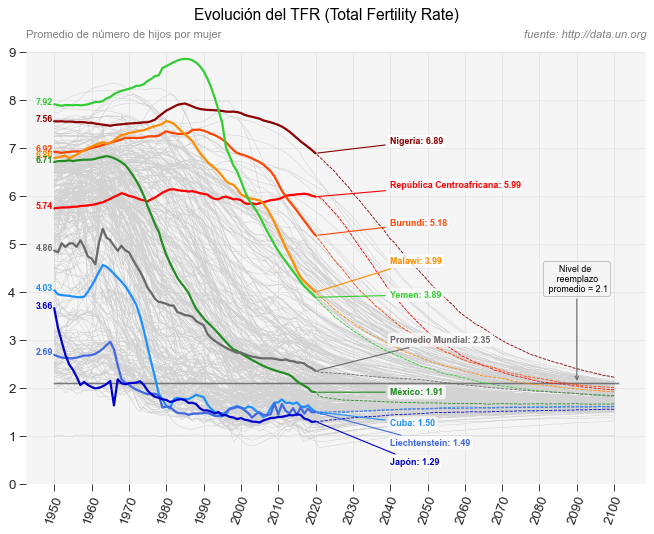

In [363]:
fig, ax = set_canvas(TFR, 'Year(s)', 'Value', 'Country or Area', (10,7))

ax.plot([years[-1], years[0]],[2.1,2.1], c='dimgray', ls = 'solid', lw=0.75)
ax.plot([years[-1], years[0]],[2.1,2.1], c='dimgray', ls = 'solid', alpha=0.25, lw=2.75) 

ax.set_title('Promedio de número de hijos por mujer', loc='left', color='gray', fontsize=10)
ax.set_title('fuente: http://data.un.org', loc='right', color='gray', fontstyle='italic', fontsize=10)
plt.suptitle('Evolución del TFR (Total Fertility Rate)', y = 0.96, color='black', fontsize=14)
ax.annotate('Nivel de \n reemplazo \n promedio = 2.1', 
             xy=(2090, 2.095), xytext=(2090, 4.0),
             bbox=dict(boxstyle='round', facecolor='whitesmoke', edgecolor='gray', alpha=0.75, linewidth=0.5),
             arrowprops=dict(arrowstyle='->', facecolor='dimgray', edgecolor='dimgray'),
             fontsize=8, color='black', horizontalalignment='center')

c_to_plot = [('Niger', 'Nigeria', 'darkred'), 
             ('Central African Republic', 'República Centroafricana', 'red'),
             ('Burundi', 'Burundi', 'orangered'),
             ('Malawi', 'Malawi', 'darkorange'),
             ('Yemen', 'Yemen', 'limegreen'), 
             ('Mexico', 'México', 'forestgreen'),
             ('Cuba', 'Cuba', 'dodgerblue'),
             ('Liechtenstein', 'Liechtenstein', 'royalblue'),
             ('Japan', 'Japón', 'mediumblue'),
             ('World', 'Promedio Mundial', 'dimgrey'),
#             ('Mongolia', 'Mongolia', 'darkorange'),
#             ('India','India','limegreen'),
#             ('United States of America', 'USA', 'deepskyblue'),
#             ('China', 'China', 'mediumblue'),
#             ('Spain','España','purple'),
#             ('Republic of Korea', 'Corea del sur', 'crimson'),
#             ('Holy See', 'Ciudad del Vaticano', 'olivedrab'),
            ]
for c in c_to_plot:
    c_tfr = TFR_group.get_group(c[0]).dropna()
    plot_country(ax, c_tfr, color=c[2])
    ytext = c_tfr['Value'][c_tfr['Year(s)'] == 2020].values[0]
    ytext_i = c_tfr['Value'][c_tfr['Year(s)'] == 1950].values[0]

    plt.text(1945, ytext_i, "{:.2f}".format(ytext_i), color = c[2], fontsize=8, fontweight='bold')

    xy_x = 2020
    xytext_x = 2040
    
    if c[0] == 'World':
        yoff = 0.6
    elif c[0] == 'Mongolia':
        yoff = 0.6
    elif c[0] == 'India':
        yoff = 0.4
    elif c[0] == 'United States of America':
        yoff = -0.2
    elif c[0] == 'Republic of Korea':
        yoff = -0.7
    elif c[0] == 'Mexico':
        yoff = -0.05
    elif c[0] == 'Malawi':
        yoff = 0.6
    elif c[0] == 'Yemen':
        yoff = 0.0
    elif c[0] == 'Japan':
        yoff = -0.9
    elif c[0] == 'Cuba':
        yoff = -0.3
    elif c[0] == 'Liechtenstein':
        yoff = -0.7
    elif c[0] == 'Holy See':
        xy_x = 1980
        xytext_x = 1965
        yoff = -0.5
    else:
        yoff = 0.2

    plt.annotate(c[1]+": {:.2f}".format(ytext), xy = (xy_x, ytext), xytext = (xytext_x, ytext+yoff), 
                     color = c[2], fontsize=8, fontweight='bold',
                     bbox=dict(boxstyle='round', fc='white', ec='gainsboro', alpha=0.75, linewidth=0.25),
                     arrowprops=dict(arrowstyle='-', color=c[2]))

plt.savefig('TFR.pdf', dpi=300)
plt.show()

In [ ]:
fig, ax = set_canvas(LEB, 'Year(s)', 'Value', 'Country or Area', (10,7), ystep=10)
plot_country(ax, LEB_group.get_group('Yemen').dropna(), color='C0', label='Yemen', maxim=2022)
plot_country(ax, LEB_group.get_group('Mexico').dropna(), color='C1', label='México', maxim=2022)
plot_country(ax, LEB_group.get_group('Germany').dropna(), color='C2', label='Alemania')
plot_country(ax, LEB_group.get_group('Holy See').dropna(), color='C3', label='El Baticano')
plot_country(ax, LEB_group.get_group('United States of America').dropna(), color='C4', label='USA')
plot_country(ax, LEB_group.get_group('Niger').dropna(), color='C5', label='Nigeria')
plot_country(ax, LEB_group.get_group('China, Hong Kong SAR').dropna(), color='C6', label='Hong Kong')
plot_country(ax, LEB_group.get_group('San Marino').dropna(), color='C8', label='San Marino')

In [ ]:
maxmin(GDP, 'Year', 'Value', 'Country or Area')

In [ ]:
fig, ax = set_canvas(GDP, 'Year', 'Value', 'Country or Area', (10,7), xstep=5, ystep=10000)
plot_country(ax, GDP_group.get_group('Yemen').dropna(), time = 'Year', color='C0', label='Yemen', maxim=2022)
plot_country(ax, GDP_group.get_group('Mexico').dropna(), time = 'Year', color='C1', label='México', maxim=2022)
plot_country(ax, GDP_group.get_group('Germany').dropna(), time = 'Year', color='C2', label='Alemania')
#plot_country(ax, GDP_group.get_group('Holy See').dropna(), time = 'Year', color='C3', label='El Baticano')
#plot_country(ax, GDP_group.get_group('United States of America').dropna(), time = 'Year', color='C4', label='USA')
plot_country(ax, GDP_group.get_group('Niger').dropna(), time = 'Year', color='C5', label='Nigeria')
plot_country(ax, GDP_group.get_group('China, Hong Kong SAR').dropna(), time = 'Year', color='C6', label='Hong Kong')
plot_country(ax, GDP_group.get_group('San Marino').dropna(), time = 'Year', color='C8', label='San Marino')

In [ ]:
maxmin(EDU, 'Time Period', 'Observation Value', 'Reference Area')

In [ ]:
fig, ax = set_canvas(EDU, 'Time Period', 'Observation Value', 'Reference Area', (10,7), xstep=5, ystep=10)
plot_country(ax, EDU_group.get_group('Yemen').dropna(), time = 'Time Period', value = 'Observation Value', color='C0', label='Yemen', maxim=2022)
plot_country(ax, EDU_group.get_group('Mexico').dropna(), time = 'Time Period', value = 'Observation Value', color='C1', label='México', maxim=2022)
plot_country(ax, EDU_group.get_group('Germany').dropna(), time = 'Time Period', value = 'Observation Value', color='C2', label='Alemania')
#plot_country(ax, EDU_group.get_group('Holy See').dropna(), time = 'Time Period', value = 'Observation Value', color='C3', label='El Baticano')
plot_country(ax, EDU_group.get_group('United States of America').dropna(), time = 'Time Period', value = 'Observation Value', color='C4', label='USA')
plot_country(ax, EDU_group.get_group('Niger').dropna(), time = 'Time Period', value = 'Observation Value', color='C5', label='Nigeria')
#plot_country(ax, EDU_group.get_group('China, Hong Kong SAR').dropna(), time = 'Time Period', value = 'Observation Value', color='C6', label='Hong Kong')
plot_country(ax, EDU_group.get_group('San Marino').dropna(), time = 'Time Period', value = 'Observation Value', color='C8', label='San Marino')

In [ ]:
for i in countries:
    print(i, end = ' ')

In [ ]:
GDP_mex = GDP_group.get_group('Mexico')

In [ ]:
GDP_mex[GDP_mex['Year'] == 2000]['Value']

In [ ]:
GDP.head()

In [282]:
tfr = pd.Series(dtype=float)
gdp = pd.Series(dtype=float)
edu = pd.Series(dtype=float)
leb = pd.Series(dtype=float)
final_countries = []
año = 2010

paises_to_remove = ['Malaysia', 'British Virgin Islands', 'Cook Islands', 'Monaco', 'Seychelles']
for p in paises_to_remove:
    countries.remove(p)

for i, c in enumerate(countries):

    c_g = EDU_group.get_group(c).groupby('Sex').get_group('Female')
    if año in c_g['Time Period'].values:
        final_countries.append(c)
        
        edu = pd.concat([edu, c_g[c_g['Time Period'] == año]['Observation Value']])
    
        c_g = GDP_group.get_group(c)
        gdp = pd.concat([gdp, c_g[c_g['Year'] == año]['Value']])
        
        c_g = TFR_group.get_group(c)
        tfr = pd.concat([tfr, c_g[c_g['Year(s)'] == año]['Value']])
        
        c_g = LEB_group.get_group(c)
        leb = pd.concat([leb, c_g[c_g['Year(s)'] == año]['Value']])

In [283]:
print(len(tfr), len(gdp), len(edu), len(leb))

118 118 118 118


In [284]:
hdi = pd.DataFrame()
hdi['País'] = final_countries
hdi['TFR'] = list(tfr)
hdi['GDP'] = list(gdp)
hdi['EDU'] = list(edu)
hdi['LEB'] = list(leb)
hdi

,País,TFR,GDP,EDU,LEB
0,Albania,1.6564,4052.927488,52.38337,77.9359
1,Algeria,2.8434,4493.635433,35.33614,73.8081
2,Antigua and Barbuda,1.7854,13038.258604,22.67580,76.8195
3,Argentina,2.3462,10023.206688,89.15845,75.7208
4,Armenia,1.5010,3462.399904,63.13266,73.1597
...,...,...,...,...,...
113,Uruguay,2.0110,11567.565434,80.32340,76.8580
114,Uzbekistan,2.4407,1789.707894,7.55595,69.2354
115,Viet Nam,1.8949,1631.765100,22.71635,73.5126
116,Yemen,4.8553,1179.830933,6.40428,67.2800


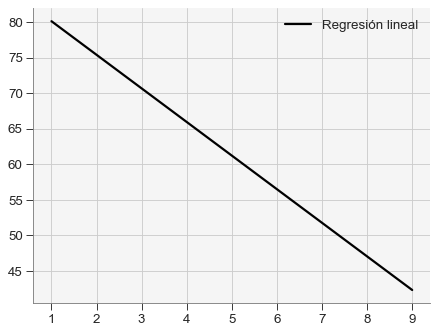

In [285]:
import scipy
lres = scipy.stats.linregress(hdi.TFR, hdi.LEB)
x = np.linspace(1,9,100)
y = lres.slope * x + lres.intercept

plt.plot(x, y, label='Regresión lineal')
plt.legend()
plt.show()

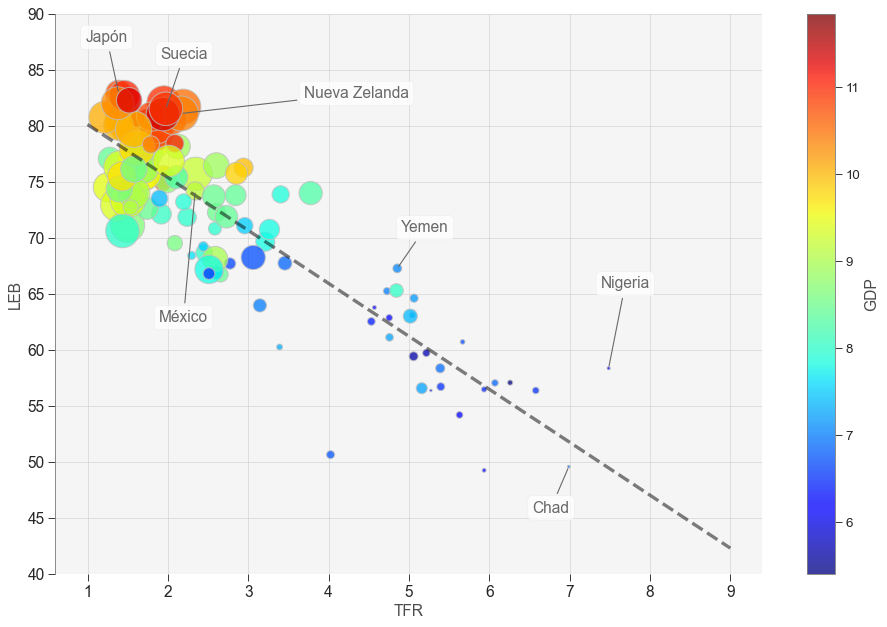

In [286]:
lista_paises = [('Yemen', 'Yemen', 'C3'), 
             ('Niger', 'Nigeria', 'navy'), 
             ('Chad', 'Chad', 'C2'),
             ('Mexico', 'México', 'darkorange'),
             ('Japan', 'Japón', 'C7'),
             ('Sweden', 'Suecia', 'C5'),
             ('New Zealand', 'Nueva Zelanda', 'olivedrab')
               ]
paises_to_plot = [hdi[hdi['País'] == p[0]] for p in lista_paises]

plt.figure(figsize=(12,8))

ax = plt.subplot(111)
niv_edu = np.array(hdi['EDU']*10.0)
gdp_val = np.array(np.log(hdi['GDP']))
scatter = ax.scatter(hdi['TFR'], hdi['LEB'], marker='o', s=niv_edu, c=gdp_val, ec='silver', cmap='jet', alpha=0.75)

#    ax.scatter(p['TFR'], p['LEB'], c='k', marker='.', label=pc[1])

xt, yt = 4, 85
ic = 0
for pa, cl in zip(paises_to_plot, lista_paises):
    if cl[0] == 'Japan':
        xt, yt = 1.5, 87.5
    elif cl[0] == 'Niger':
        xt, yt = 8, 65.5
    elif cl[0] == 'Chad':
        xt, yt = 7, 45.5
    elif cl[0] == 'Yemen':
        xt, yt = 5.5, 70.5
    elif cl[0] == 'Mexico':
        xt, yt = 2.5, 62.5
    elif cl[0] == 'New Zealand':
        xt, yt = 5, 82.5
    elif cl[0] == 'Sweden':
        xt, yt = 2.5, 86


    niv_edu = np.array(pa['EDU']*10.0)
    gdp_val = np.array(np.log(pa['GDP']))
    ax.scatter(pa['TFR'], pa['LEB'], marker='o', s=niv_edu, c=gdp_val, ec='silver', cmap='jet', alpha=0.01, zorder=25)

    plt.annotate(cl[1], xy = (pa['TFR'], pa['LEB']), xytext = (xt, yt), 
                     color = 'dimgray', fontsize=14, fontweight='normal', ha='right',
                     bbox=dict(boxstyle='round', fc='white', ec='gainsboro', alpha=0.75, linewidth=0.25),
                     arrowprops=dict(arrowstyle='-', color='dimgray'))
    
ax.plot(x,y,'k--', alpha=0.5, lw=3)
ax.set_xlabel('TFR')
ax.set_ylabel('LEB')
ax.set_xticks([i for i in range(1,10)], labels=[i for i in range(1,10)], fontsize=14 )
ax.set_yticks([yt for yt in range(40,95,5)], labels=[yt for yt in range(40,95,5)], fontsize=14)
ax.spines['bottom'].set_visible(False)
ax.grid(lw=0.5)
plt.colorbar(mappable=scatter, label='GDP')

plt.tight_layout()
plt.savefig('FINAL.pdf')

In [ ]:


#ax1 = plt.subplot(221)
#hdi.plot(x='TFR', y='GDP', kind='scatter', fc='gainsboro', ec='silver', alpha=0.75, ax = ax1)
#for p, pc in zip(paises_to_plot, lista_paises):
#    ax1.scatter(p['TFR'], p['GDP'], c=pc[2], zorder=5, alpha=0.75)
#ax1.set_xticks([i for i in range(1,10)])

#se = np.array(hdi['GDP']*0.5e-2)
#ax2 = plt.subplot(222)
#hdi.plot(x='TFR', y='EDU', kind='scatter', fc='gainsboro', ec='silver', alpha=0.75, ax = ax2)
#scatter = ax2.scatter(hdi['TFR'], hdi['EDU'], marker='o', s=se, c=se, cmap='viridis', alpha=0.75)
#for p, pc in zip(paises_to_plot, lista_paises):
#    ax2.scatter(p['TFR'], p['EDU'], s=p['GDP']*0.5e-2, alpha=0.75,  c=pc[2], label=pc[1])

#ax2.set_xticks([i for i in range(1,10)])
#ax2.legend(ncol=2)




#ax3.legend(loc='upper right', bbox_to_anchor=(1.95, 0.95))

#ax4 = plt.subplot(234)
#hdi.plot(x='GDP', y='EDU', kind='scatter', fc='gainsboro', ec='silver', alpha=0.75, ax = ax4)
#for p, pc in zip(paises_to_plot, lista_paises):
#    ax4.scatter(p['GDP'], p['EDU'], alpha=0.85, c=pc[2])
#ax4.set_xscale('log')

#ax5 = plt.subplot(224)
#hdi.plot(x='GDP', y='LEB', kind='scatter', fc='gainsboro', ec='silver', alpha=0.75, ax = ax5)
#for p, pc in zip(paises_to_plot, lista_paises):
#    ax5.scatter(p['GDP'], p['LEB'], alpha=0.85, c=pc[2])
#ax5.set_xscale('log')

#ax6 = plt.subplot(236)
#hdi.plot(x='LEB', y='EDU', kind='scatter', fc='gainsboro', ec='silver', alpha=0.75, ax = ax6)
#for p, pc in zip(paises_to_plot, lista_paises):
#    ax6.scatter(p['LEB'], p['EDU'], alpha=0.85, c=pc[2])



In [287]:
hdi['HDI'] = np.cbrt(hdi.TFR * hdi.EDU * hdi.LEB)

In [288]:
hdi['HDI'] = hdi.HDI / hdi.HDI.max()

In [289]:
hdi

,País,TFR,GDP,EDU,LEB,HDI
0,Albania,1.6564,4052.927488,52.38337,77.9359,0.719815
1,Algeria,2.8434,4493.635433,35.33614,73.8081,0.742293
2,Antigua and Barbuda,1.7854,13038.258604,22.67580,76.8195,0.555621
3,Argentina,2.3462,10023.206688,89.15845,75.7208,0.955952
4,Armenia,1.5010,3462.399904,63.13266,73.1597,0.725812
...,...,...,...,...,...,...
113,Uruguay,2.0110,11567.565434,80.32340,76.8580,0.881393
114,Uzbekistan,2.4407,1789.707894,7.55595,69.2354,0.412952
115,Viet Nam,1.8949,1631.765100,22.71635,73.5126,0.558836
116,Yemen,4.8553,1179.830933,6.40428,67.2800,0.486832


-0.08804520907984292 0.8975361617317406 0.5010566535168528


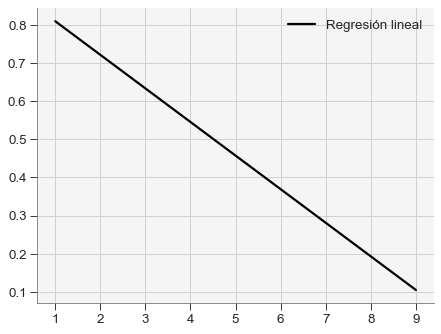

In [313]:
lres = scipy.stats.linregress(hdi.TFR, hdi.HDI)
print(lres.slope, lres.intercept, lres.rvalue**2)
x = np.linspace(1,9,100)
y = lres.slope * x + lres.intercept

plt.plot(x, y, label='Regresión lineal')
plt.legend()
plt.show()

In [291]:
hdi_respaldo = hdi.copy()

In [292]:
hdi.sort_values('EDU', inplace = True)

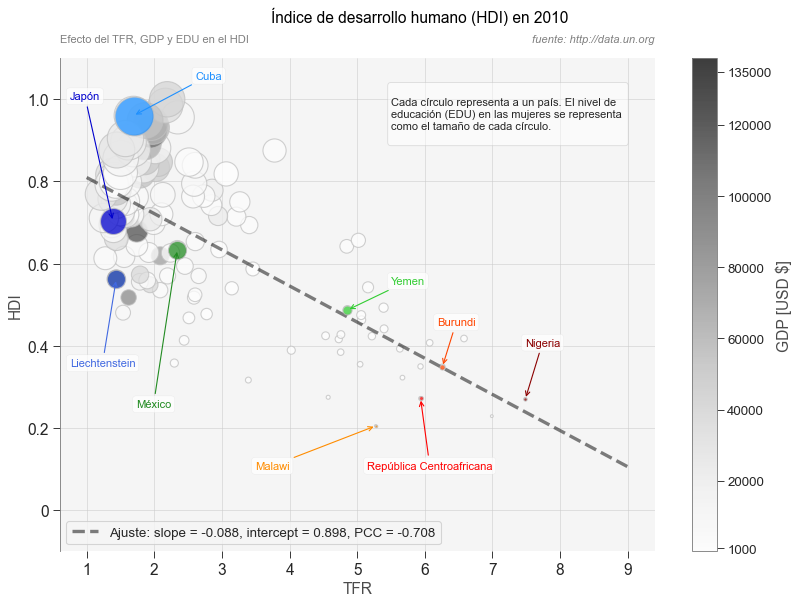

In [364]:
lista_paises = [('Niger', 'Nigeria', 'darkred'), 
             ('Central African Republic', 'República Centroafricana', 'red'),
             ('Burundi', 'Burundi', 'orangered'),
             ('Malawi', 'Malawi', 'darkorange'),
             ('Yemen', 'Yemen', 'limegreen'), 
             ('Mexico', 'México', 'forestgreen'),
             ('Cuba', 'Cuba', 'dodgerblue'),
             ('Liechtenstein', 'Liechtenstein', 'royalblue'),
             ('Japan', 'Japón', 'mediumblue')
               ]

paises_to_plot = [hdi[hdi['País'] == p[0]] for p in lista_paises]

plt.figure(figsize=(12,8))

ax = plt.subplot(111)
niv_edu = np.array(hdi['EDU']*10.0)
#gdp_val = np.array(np.log(hdi['GDP']))
gdp_val = np.array(hdi['GDP'])

scatter = ax.scatter(hdi['TFR'], hdi['HDI'], marker='o', s=niv_edu, c=gdp_val, ec='silver', cmap='Greys', alpha=0.75)

#    ax.scatter(p['TFR'], p['LEB'], c='k', marker='.', label=pc[1])


ha = 'right'
for pa, cl in zip(paises_to_plot, lista_paises):
    if cl[0] == 'Yemen':
        xt, yt = 6., 0.55
    elif cl[0] == 'Niger':
        xt, yt = 8, 0.4
    elif cl[0] == 'India':
        xt, yt = 3.0, 0.2
    elif cl[0] == 'Yemen':
        xt, yt = 4.5, 1.0
    elif cl[0] == 'Mexico':
        xt, yt = 2.25, .25
    elif cl[0] == 'Liechtenstein':
        xt, yt = 0.75, 0.35
        ha = 'left'
    elif cl[0] == 'Burundi':
        xt, yt = 6.75, 0.45
    elif cl[0] == 'Central African Republic':
        xt, yt = 7, 0.1
    elif cl[0] == 'Malawi':
        xt, yt = 4, 0.1
    elif cl[0] == 'Republic of Korea':
        xt, yt = 0.65, 1.05
    elif cl[0] == 'Cuba':
        xt, yt = 3, 1.05
    else:
        xt, yt = 0.75, 1.0

    niv_edu = np.array(pa['EDU']*10.0)
    gdp_val = np.array(np.log(pa['GDP']))
    ax.scatter(pa['TFR'], pa['HDI'], marker='o', s = niv_edu, fc=cl[2], ec='silver', alpha=0.75, zorder=15)

    plt.annotate(cl[1], xy = (pa['TFR'], pa['HDI']), xytext = (xt, yt), zorder=20,
                     color = cl[2], fontsize=10, fontweight='normal', ha=ha,
                     bbox=dict(boxstyle='round', fc='white', ec='gainsboro', alpha=0.75, linewidth=0.25),
                     arrowprops=dict(arrowstyle='->', color=cl[2]))
    
ax.plot(x,y,'k--', alpha=0.5, lw=3, label='Ajuste: slope = {:0.3f}, intercept = {:0.3f}, PCC = {:0.3f}'.format(lres.slope, lres.intercept, lres.rvalue))
ax.set_xlabel('TFR')
ax.set_ylabel('HDI')
ax.set_xticks([i for i in range(1,10)], labels=[i for i in range(1,10)], fontsize=14 )
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0], labels=[0,0.2,0.4,0.6,0.8,1.0], fontsize=14)
ax.set_ylim(-0.1, 1.1)
ax.spines['bottom'].set_visible(False)
ax.grid(lw=0.5)
ax.set_title('Efecto del TFR, GDP y EDU en el HDI', loc='left', color='gray', fontsize=10)
ax.set_title('fuente: http://data.un.org', loc='right', color='gray', fontstyle='italic', fontsize=10)
plt.suptitle('Índice de desarrollo humano (HDI) en 2010', y = 0.96, color='black', fontsize=14)
texto = """ 
Cada círculo representa a un país. El nivel de
educación (EDU) en las mujeres se representa 
como el tamaño de cada círculo.
"""
plt.text(5.5,0.9,texto, fontsize=10,bbox=dict(boxstyle='round', fc='white', ec='silver', alpha=0.5, linewidth=0.75))
plt.colorbar(mappable=scatter, label='GDP [USD $]', ticks=[1000, 20000, 40000, 60000, 80000, 100000, 120000, 135000])
plt.legend(loc='lower left', frameon=True)

plt.savefig('HDI.pdf', dpi = 300)

In [242]:
hdi.sort_values('GDP')

,País,TFR,GDP,EDU,LEB,HDI
20,Burundi,6.2599,221.476790,2.16036,57.0809,0.349181
60,Liberia,5.0583,276.793239,6.44251,59.4331,0.474480
37,Ethiopia,5.2168,294.290089,4.40732,59.7300,0.423103
64,Madagascar,4.7553,452.531442,3.43914,62.8729,0.384196
78,Niger,7.4854,457.692958,0.81802,58.3668,0.270128
...,...,...,...,...,...,...
63,Luxembourg,1.6199,75267.334123,19.23368,80.5731,0.517331
104,Switzerland,1.5187,80534.047000,52.51459,82.2831,0.712650
79,Norway,1.9389,88636.147327,90.37135,81.0401,0.921759
14,Bermuda,1.7400,104640.739515,40.60865,80.4985,0.679475


In [152]:
hdi['País'].values

array(['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda',
       'Bhutan', 'Bosnia and Herzegovina', 'Brunei Darussalam',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros',
       'Croatia', 'Cuba', 'Cyprus', 'Denmark', 'Djibouti', 'Egypt',
       'El Salvador', 'Eritrea', 'Estonia', 'Ethiopia', 'Finland',
       'France', 'Gambia', 'Georgia', 'Greece', 'Guinea', 'Guyana',
       'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Ireland',
       'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kyrgyzstan',
       "Lao People's Democratic Republic", 'Latvia', 'Lebanon', 'Liberia',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi',
       'Mali', 'Malta', 'Mauritania', 'Mauritius', 'Mexico', 'Mongolia',
       'Monteneg

In [ ]:


#ax2 = plt.subplot(222)
#hdi.plot(x='GDP', y='HDI', kind='scatter', fc='gainsboro', ec='silver', alpha=0.75, ax = ax2)
#for p in paises_to_plot:
#    ax2.scatter(p['GDP'], p['HDI'], alpha=0.75)
#ax2.set_xscale('log')
#ax2.set_xticks([i for i in range(0,10)])

#ax3 = plt.subplot(223)
#hdi.plot(x='LEB', y='HDI', kind='scatter', fc='gainsboro', ec='silver', alpha=0.75, ax = ax3)
#for p in paises_to_plot:
#    ax3.scatter(p['LEB'], p['HDI'], alpha=0.75)
#ax3.set_xticks([i for i in range(0,10)])

#ax4 = plt.subplot(224)
#hdi.plot(x='EDU', y='HDI', kind='scatter', fc='gainsboro', ec='silver', alpha=0.75, ax = ax4)
#for p in paises_to_plot:
#    ax4.scatter(p['EDU'], p['HDI'], alpha=0.75)
#ax3.set_xticks([i for i in range(0,10)])

#plt.tight_layout()
#plt.savefig('FINAL2.pdf')